In [1]:
# Importing the necessary libraries
from scipy import ndimage, misc, stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import cv2

# Change window size
%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (15.0, 7.5)

# Utility functions for getting and showing images
def get_image(file):	
    return np.matrix(ndimage.imread(file, mode = "L"))
		
    
def show_image(image):
    plt.imshow((image), cmap = 'Greys_r')
    
def save_image(file, mat):
    misc.imsave(file.split(".")[0] + "_processed.png", mat)  
    
def get_levels(image, num_levels):
    output = [] # Initialize the output vector
    for i in range(num_levels):
        output.append(misc.imresize(image, 
                                    (image.shape[0]/2**i,
                                     image.shape[1]/2**i))) # Shrink the image by 75% each time
    return output
        
def get_octave(image, num_layers, k):
    # Initialize the gaussian and difference of gaussian vectors
    gaussians = [] 
    diff_of_gaussians = []
    
    # Calculate the gaussians, multiplying sigma by k each time
    for i in xrange(1,num_layers+1):
        gaussians.append(ndimage.filters.gaussian_filter(image, k**i))
        
    # Calculate the difference of gaussians, and add a pixel intensity 
    # offset of 128 to account for weird looping cases
    for j in xrange(num_layers-1):
        diff_of_gaussians.append(gaussians[j+1] - gaussians[j] + 128)
    return diff_of_gaussians

def get_pyramid(image, num_levels, num_layers, k):
    pyramid = [] # Initialize the output
    
    levels = get_levels(image, num_levels) # Create the scale pyramid
    
    for l in levels: # Create the octave for each scale
        layers = get_octave(l, num_layers, k)
        pyramid.append(layers)
    return pyramid

def get_keypoints(i1, i2, i3):
    maxima = []
    
    # Scan the image, with an offset of 1 for each border
    for x in range(1, i2.shape[0] - 1):
        for y in range(1, i2.shape[1] - 1):
            if is_maximum(i1,i2, i3, x, y):
                maxima.append([x,y])
                
    return maxima

def is_maximum(i1, i2, i3, x, y):
    pix = i2[x,y]
    middle_maxima = []
    
    # Find the indices of the maximum point in each layer
    bottom_max = np.unravel_index(i1[x-1:x+2, y-1:y+2].argmax(), (3,3))
    middle_max = np.unravel_index(i2[x-1:x+2, y-1:y+2].argmax(), (3,3))
    top_max = np.unravel_index(i3[x-1:x+2, y-1:y+2].argmax(), (3,3))

    # Check the bottom, middle and top layers for maxima
    if i1[bottom_max] >= pix or i2[middle_max] > pix or i3[top_max] >= pix:
        return False
    
    # If pix is the maxima, check for duplicates 
    for i in range(0, 3):
        for j in range(0,3):
            if i2[x-1+i, y-1+j] == i2[middle_max]:
                middle_maxima.append([x-1+i, y-1+i])
    
    if len(middle_maxima) != 1:
        return False 
    else: 
        return True
    

def get_all_keypoints(pyramid):
    all_keypoints = [] # Initialize the output
    for l in pyramid: # Layers
        keypoint_level = [] 
        for i in xrange(1,len(l) - 1):
            keypoint_level.append(get_keypoints(l[i-1], l[i], l[i+1]))
        all_keypoints.append(keypoint_level)
        
    return all_keypoints

def draw_keypoints(im, keyp):
    x = [item[1] for item in keyp]
    y = [item[0] for item in keyp]
    plt.imshow(im, cmap = "Greys_r")
    plt.scatter(x, y, color = "yellow", marker = "+")
    plt.show()
    


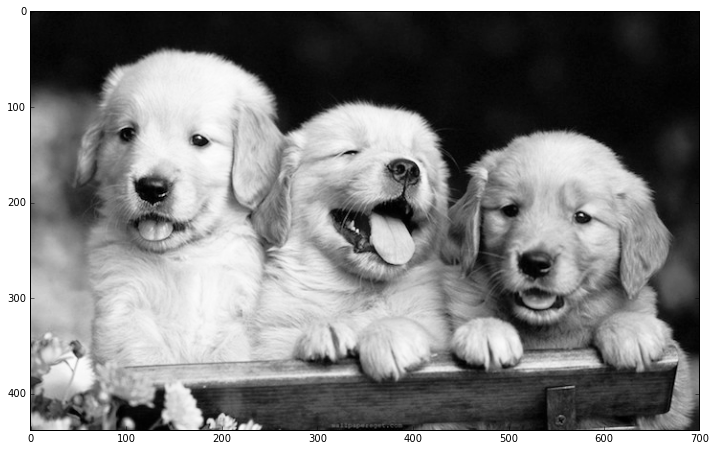

In [2]:
# Test image
image = get_image('dog.jpg')
plt.imshow((image), cmap = 'Greys_r')

# According to the paper, k should equal 2 * (1/s) where s is the number of layers in each octave
k = 2 ** (0.5) 
p = get_pyramid(image, 3, 5, k)
# Check that the get_all_keypoints function is working correctly
kp = get_all_keypoints(p)

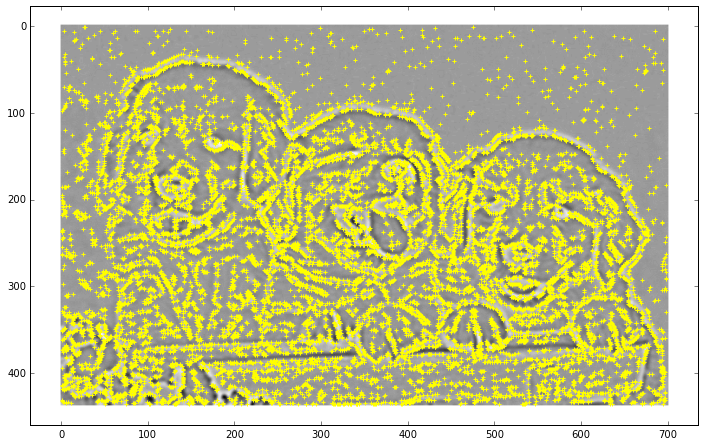

In [3]:
# Show a test image
draw_keypoints(p[0][1], kp[0][0])